In [45]:
%matplotlib inline

In [74]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical

import pandas as pd

In [47]:
env = gym.make('Acrobot-v1')
env.seed(1)
torch.manual_seed(1)

In [48]:
#Hyperparameters
learning_rate = 0.01
gamma = 0.99

In [55]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128, self.action_space, bias=False)
        
        self.gamma = gamma
        
        self.policy_history = Variable(torch.Tensor())
        self.reward_episode = []
        
        self.reward_history = []
        self.loss_history = []
        
    def forward(self, x):
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)

In [61]:
def select_action(state):
    state = Variable(torch.from_numpy(state).type(torch.FloatTensor))
    state = policy(state)
    c = Categorical(state)
    action = c.sample()
    
    if policy.policy_history.dim() != 0:
        policy.policy_history = torch.cat([policy.policy_history, c.log_prob(action)])
    else:
        policy.policy_history = (c.log_prob(action))
    return action

In [66]:
def update_policy():
    R = 0
    rewards = []
    
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0, R)
        
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    loss = (torch.sum(torch.mul(policy.policy_history, Variable(rewards)).mul(-1), -1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    policy.loss_history.append(loss.data[0])
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = Variable(torch.Tensor())
    policy.reward_episode = []

In [70]:
def main(episodes):
    running_reward = 10
    for episode in range(episodes):
        state = env.reset()
        done = False
        
        for time in range(1000):
            action = select_action(state)
            state, reward, done, _ = env.step(action.data[0])
            policy.reward_episode.append(reward)
            
            if done:
                break
                
        running_reward = running_reward*.99 + time*.01
        
        update_policy()
        
        if episode % 50 == 0:
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(episode, time, running_reward))
#         if running_reward > env.spec.reward_threshold:
#             print("Solved! Running reward is now {} and the last episode runs to {} time steps!".format(running_reward, time))
#             break

In [71]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
episodes = 1000

In [72]:
main(episodes)

Episode 0	Last length:   198	Average length: 11.88
Episode 50	Last length:   139	Average length: 72.34
Episode 100	Last length:   100	Average length: 86.72
Episode 150	Last length:    91	Average length: 89.63
Episode 200	Last length:   115	Average length: 101.36
Episode 250	Last length:    95	Average length: 100.39
Episode 300	Last length:    81	Average length: 97.51
Episode 350	Last length:   163	Average length: 98.56
Episode 400	Last length:   499	Average length: 160.55
Episode 450	Last length:   385	Average length: 225.55
Episode 500	Last length:   499	Average length: 332.95
Episode 550	Last length:   499	Average length: 398.54
Episode 600	Last length:   499	Average length: 438.22
Episode 650	Last length:   499	Average length: 462.23
Episode 700	Last length:   499	Average length: 476.75
Episode 750	Last length:   499	Average length: 485.54
Episode 800	Last length:   499	Average length: 490.86
Episode 850	Last length:   499	Average length: 494.07
Episode 900	Last length:   499	Averag

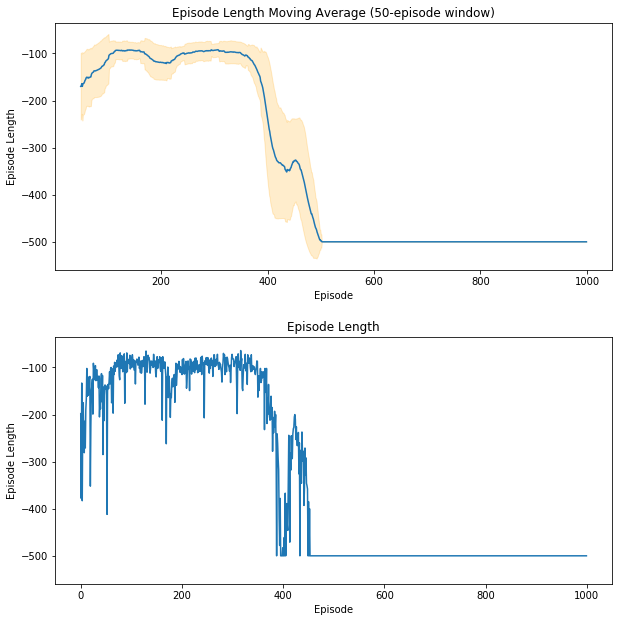

In [75]:
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')
